# **Disaster Or Not?**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("display.float", "{:.4f}".format)

%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
print(f"TRAIN shape: {train.shape}")
print(f"TEST shape: {test.shape}")

TRAIN shape: (7613, 5)
TEST shape: (3263, 4)


# 1. **Keyword and Location**

In [6]:
for column in train.columns:
    if train[column].isna().sum() != 0:
        print(f"{column} has :{train[column].isna().sum() / len(train) * 100:.2f}% Missing values")

keyword has :0.80% Missing values
location has :33.27% Missing values


In [7]:
for column in test.columns:
    if test[column].isna().sum() != 0:
        print(f"{column} has :{test[column].isna().sum() / len(test) * 100:.2f}% Missing values")

keyword has :0.80% Missing values
location has :33.86% Missing values


Since missing value ratios between training and test set are too close, **they are most probably taken from the same sample**. Missing values in those features are filled with `no_keyword` and `no_location` respectively.

In [8]:
missing_cols = ['keyword', 'location']

for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f"no_{col}")

In [9]:
print(f"Missing Values in TRAIN: {train.isna().sum().sum()}")
print(f"Missing Values in TEST: {test.isna().sum().sum()}")

Missing Values in TRAIN: 0
Missing Values in TEST: 0


In [10]:
print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


Locations are not automatically generated, they are user inputs. That's why `location` is very dirty and there are too many unique values in it. It shouldn't be used as a feature.

Fortunately, there is signal in `keyword` because some of those words can only be used in one context. Keywords have very different tweet counts and target means. `keyword` can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on `keyword`.

In [11]:
train.drop('location', axis=1, inplace=True)
test.drop('location', axis=1, inplace=True)

In [12]:
train['keyword'] = train.keyword.str.replace('%20', ' ')

In [13]:
train['keyword'] = train.keyword.apply(lambda x: 'fire' if 'fire' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'accident' if 'accident' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'wreck' if 'wreck' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'bomb' if 'bomb' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'burn' if 'burn' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'body bag' if 'body bag' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'destroy' if 'destroy' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'terrorist' if 'terror' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'emergency' if 'emergency' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'collapse' if 'collapse' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'murder' if 'murder' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'storm' if 'storm' in x else x)
train['keyword'] = train.keyword.apply(lambda x: 'disaster' if 'disaster' in x else x)

In [14]:
from nltk.stem import PorterStemmer # for finding the root words

ps = PorterStemmer()
train['keyword'] = train.keyword.apply(lambda x: ps.stem(x))

In [15]:
len(train.keyword.value_counts())

137

Text(0.5, 1.0, 'Keywords Value counts')

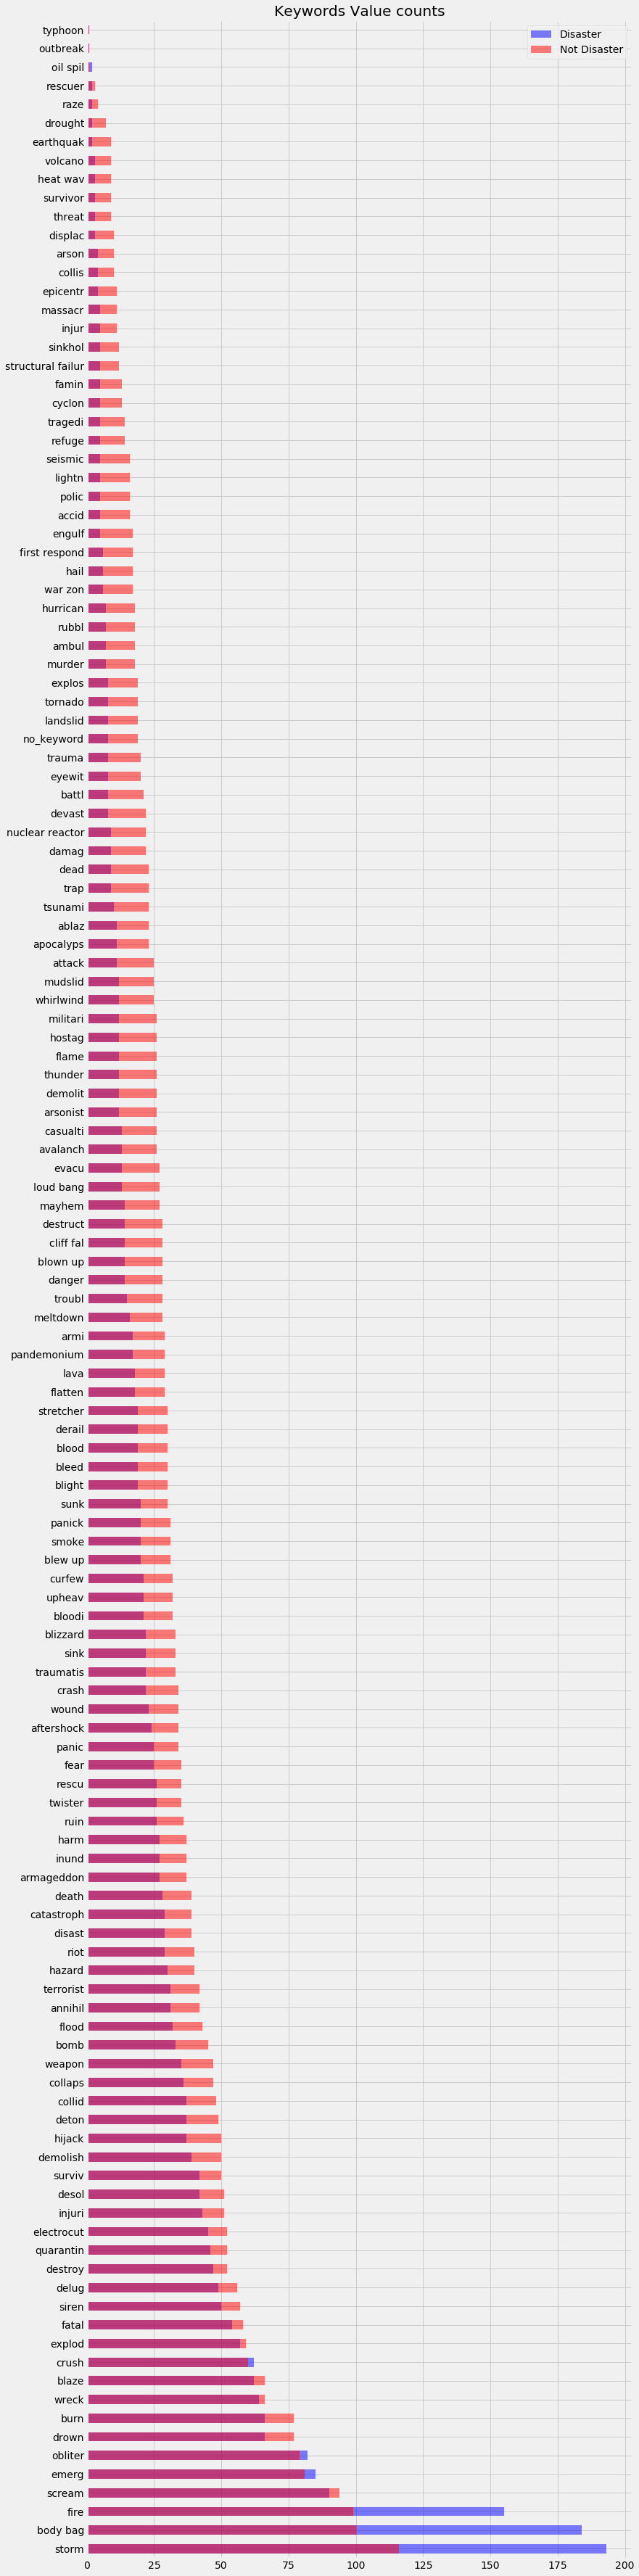

In [16]:
plt.figure(figsize=(12, 60))
train[train.target == 1].keyword.value_counts().plot(kind='barh', 
                                                     color='blue', 
                                                     alpha=0.5, 
                                                     label='Disaster')
train[train.target == 0].keyword.value_counts().plot(kind='barh', 
                                                     color='red', 
                                                     alpha=0.5, 
                                                     label='Not Disaster')
plt.legend()
plt.title('Keywords Value counts')

# **2. Meta Features**
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are:
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [17]:
from wordcloud import STOPWORDS
from string import punctuation

train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

train['stop_word_count'] = train['text'].apply(lambda x: len([1 for word in x.lower().split(' ') if word in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([1 for word in x.lower().split(' ') if word in STOPWORDS]))

train['url_count'] = train['text'].apply(lambda x: x.count('http'))
test['url_count'] = test['text'].apply(lambda x: x.count('http'))

train['char_count'] = train['text'].apply(lambda x: len(x))
test['char_count'] = test['text'].apply(lambda x: len(x))

train['punctuation_count'] = train['text'].apply(lambda x: len([1 for word in x.lower().split(' ') if word in punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([1 for word in x.lower().split(' ') if word in punctuation]))

train['hashtag_count'] = train['text'].apply(lambda x: x.count('#'))
test['hashtag_count'] = test['text'].apply(lambda x: x.count('#'))

train['mention_count'] = train['text'].apply(lambda x: x.count('@'))
test['mention_count'] = test['text'].apply(lambda x: x.count('@'))

All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as `url_count`, `hashtag_count` and `mention_count`.

On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

In [18]:
columns = train.drop(['id', 'keyword', 'text', 'target'], axis=1).columns.to_list()

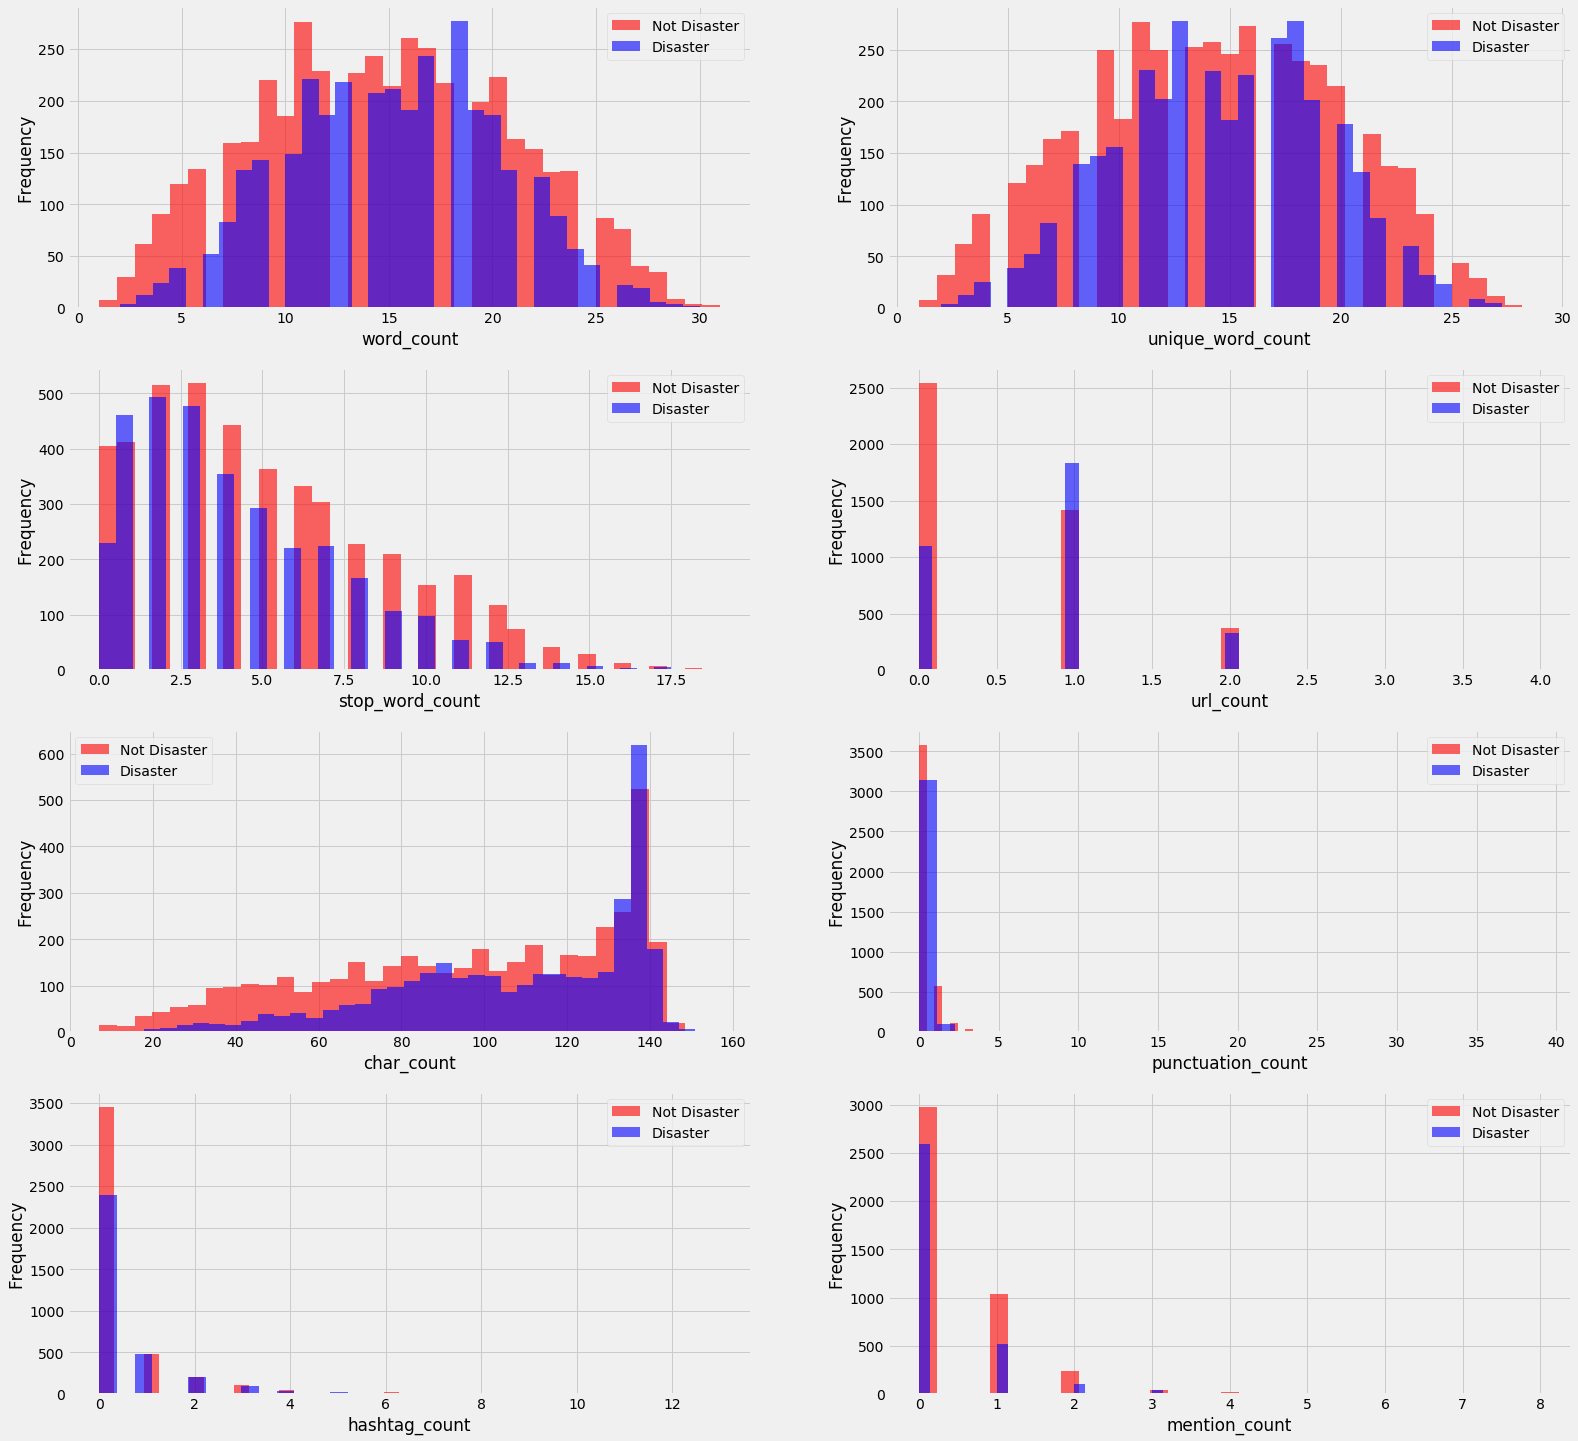

In [19]:
plt.figure(figsize=(24, 30))

for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    train[train.target==0][column].plot(bins=35, kind='hist', color='red', 
                                           label='Not Disaster', alpha=0.6)
    train[train.target==1][column].plot(bins=35, kind='hist', color='blue', 
                                           label='Disaster', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

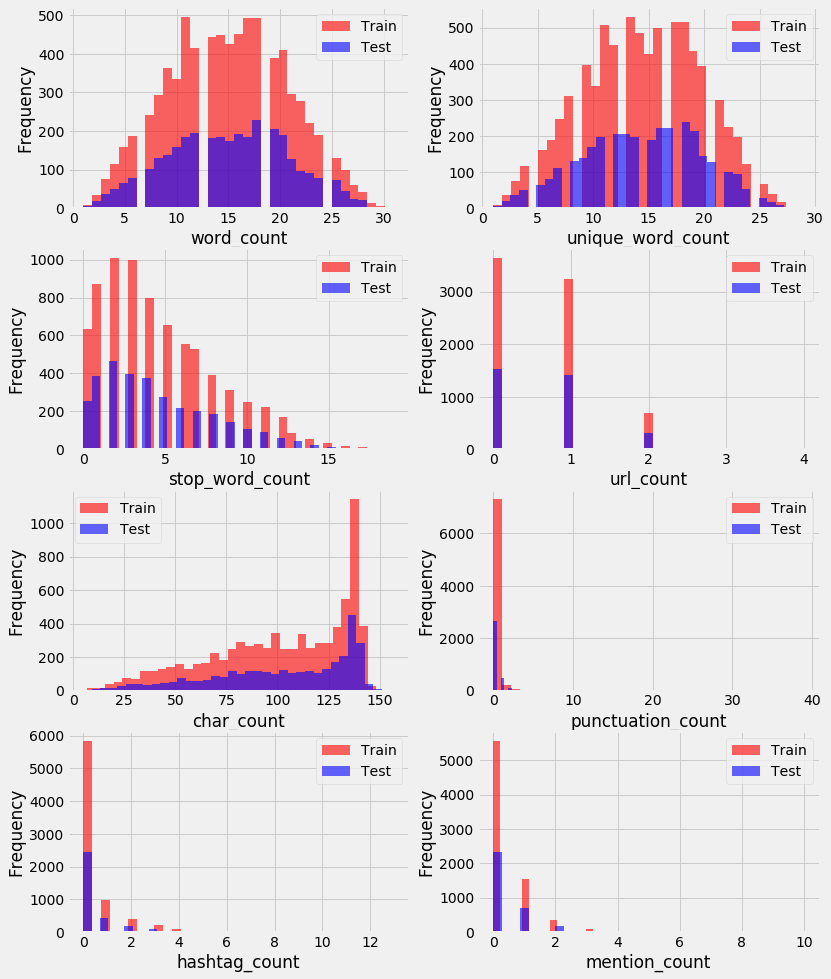

In [20]:
plt.figure(figsize=(12, 20))

for i, column in enumerate(columns, 1):
    plt.subplot(5, 2, i)
    train[column].plot(bins=35, kind='hist', color='red', 
                       label='Train', alpha=0.6)
    test[column].plot(bins=35, kind='hist', color='blue', 
                      label='Test', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

# 3. **N-gram Analysis**

Remove stop words like and, or, the, a, ... As this word apairs in allmost all english sentences they will not help our model.

In [21]:
# Non-disaster word counts
from collections import Counter
not_disaster = Counter()
for row in train[train.target == 0].text.str.split(' '):
    not_disaster.update(row)

# Disaster word counts
disaster = Counter()
for row in train[train.target == 1].text.str.split(' '):
    disaster.update(row)

Text(0.5, 1.0, 'Top 50 most common unigrams in Disaster Tweets')

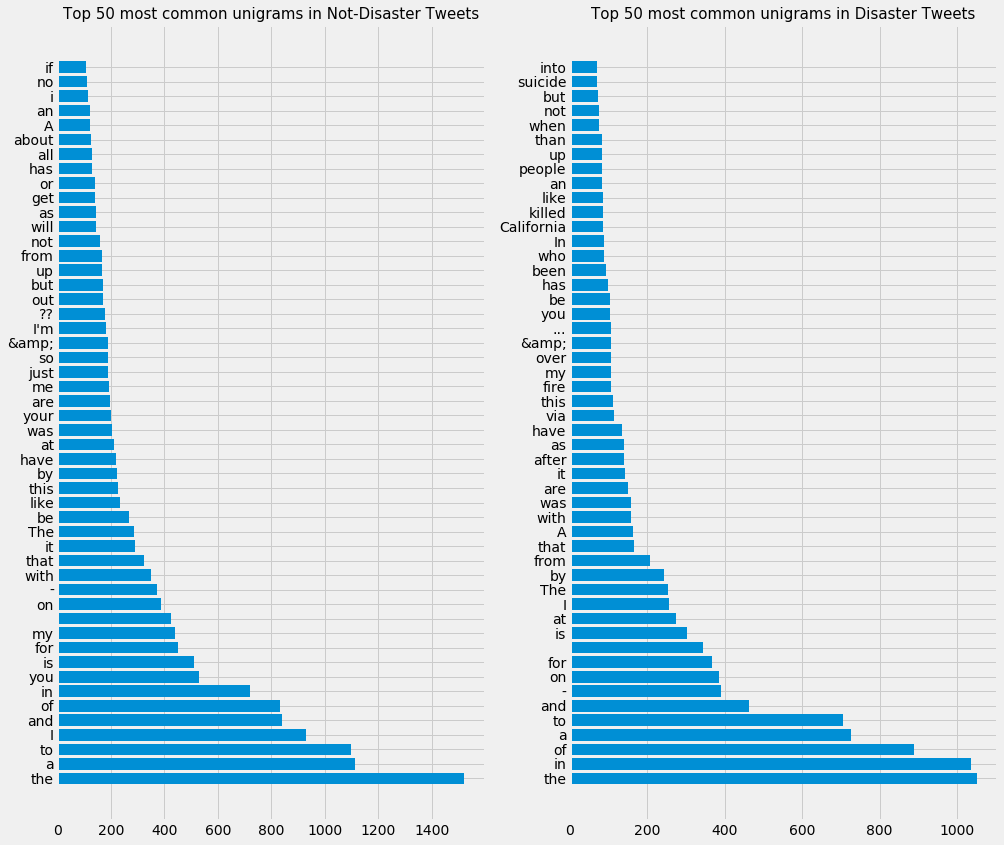

In [22]:
not_disaster = dict(not_disaster.most_common(50))
disaster = dict(disaster.most_common(50))
plt.figure(figsize=(15, 30))

plt.subplot(2, 2, 1)
plt.barh(list(not_disaster.keys()), list(not_disaster.values()))
plt.title('Top 50 most common unigrams in Not-Disaster Tweets', fontsize=15)

plt.subplot(2, 2, 2)
plt.barh(list(disaster.keys()), list(disaster.values()))
plt.title('Top 50 most common unigrams in Disaster Tweets', fontsize=15)

Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about `target`.

Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

In [23]:
train["clean_text"] = train.text.apply(lambda x: ' '.join([w for w in str(x).lower().split() 
                                                           if w not in STOPWORDS and w.isalpha()]))
test["clean_text"] = test.text.apply(lambda x: ' '.join([w for w in str(x).lower().split() 
                                                         if w not in STOPWORDS and w.isalpha()]))

Now we will counts the apearance of each word in Disaster comment as well as in Non-Disaster comment.

In [24]:
# Non-disaster word counts
not_disaster = Counter()
for row in train[train.target == 0].clean_text.str.split(' '):
    not_disaster.update(row)
    
# Disaster word counts
disaster = Counter()
for row in train[train.target == 1].clean_text.str.split(' '):
    disaster.update(row)

Text(0.5, 1.0, 'Top 50 most common unigrams in Disaster Tweets')

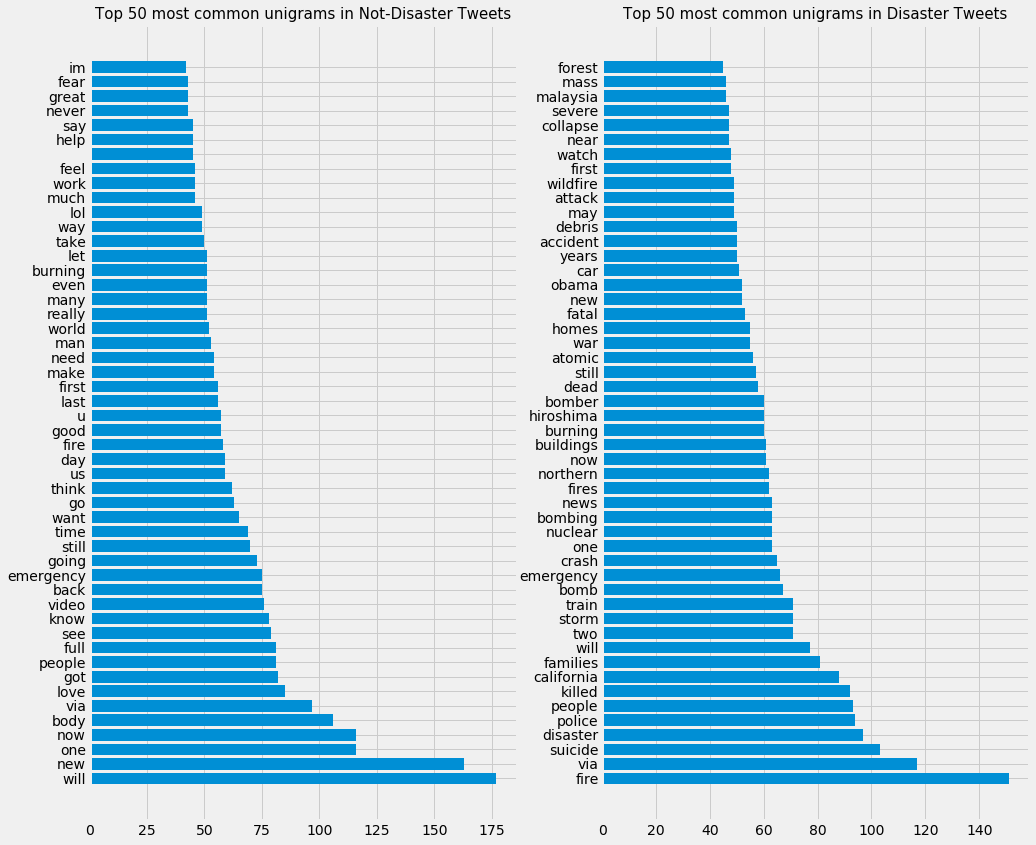

In [25]:
not_disaster = dict(not_disaster.most_common(50))
disaster = dict(disaster.most_common(50))
plt.figure(figsize=(15, 30))

plt.subplot(2, 2, 1)
plt.barh(list(not_disaster.keys()), list(not_disaster.values()))
plt.title('Top 50 most common unigrams in Not-Disaster Tweets', fontsize=15)

plt.subplot(2, 2, 2)
plt.barh(list(disaster.keys()), list(disaster.values()))
plt.title('Top 50 most common unigrams in Disaster Tweets', fontsize=15)

## **Bi-gram analysis**

In [26]:
import nltk
from nltk import word_tokenize 
from nltk.util import ngrams

bigrams = Counter()
for tweet in train[train.target == 1].text.str.lower():
    bigrams.update(ngrams(tweet.split(' '), 2))
    
disaster = dict()
for key, value in dict(bigrams.most_common(50)).items():
#     print(' '.join(key))
    disaster[' '.join(key)] = value
    
bigrams = Counter()
for tweet in train[train.target == 0].text.str.lower():
    bigrams.update(ngrams(tweet.split(' '), 2))
    
not_disaster = dict()
for key, value in dict(bigrams.most_common(50)).items():
#     print(' '.join(key))
    not_disaster[' '.join(key)] = value

Text(0.5, 1.0, 'Top 50 most common bigrams in Disaster Tweets')

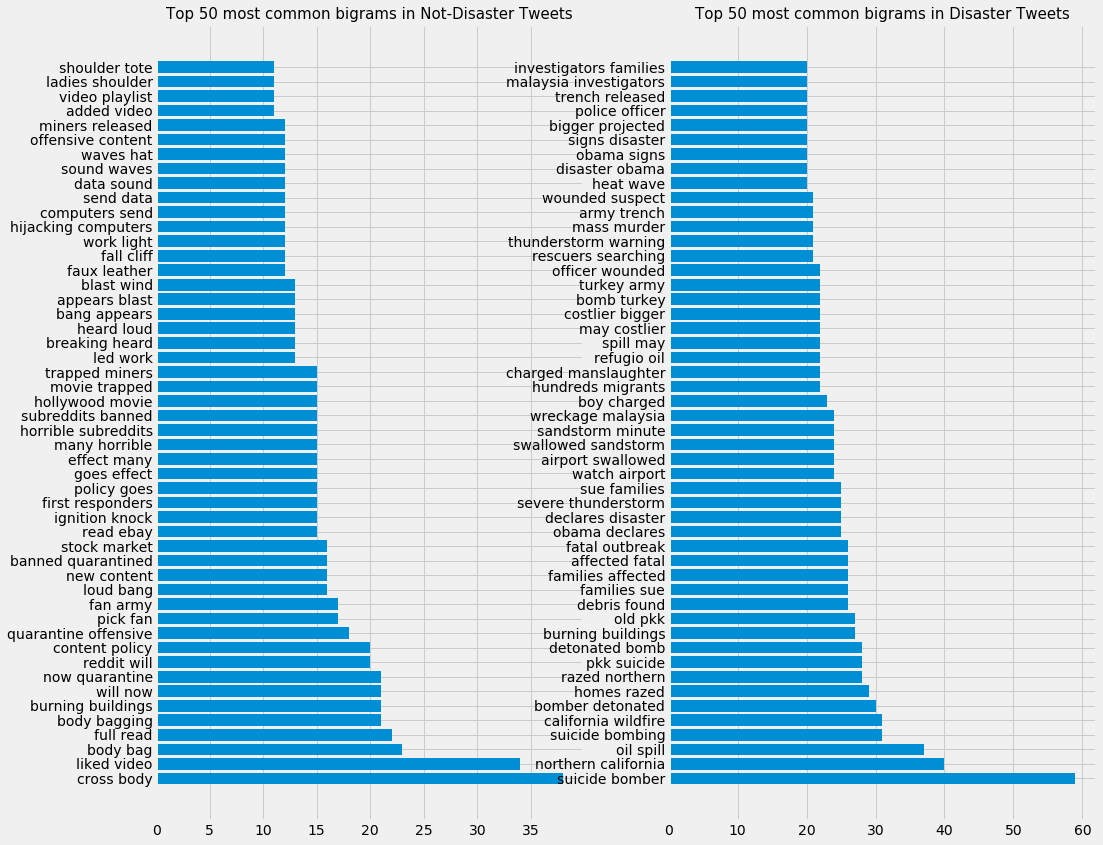

In [30]:
plt.figure(figsize=(15, 30))

plt.subplot(2, 2, 1)
plt.barh(list(not_disaster.keys()), list(not_disaster.values()))
plt.title('Top 50 most common bigrams in Not-Disaster Tweets', fontsize=15)

plt.subplot(2, 2, 2)
plt.barh(list(disaster.keys()), list(disaster.values()))
plt.title('Top 50 most common bigrams in Disaster Tweets', fontsize=15)

In [28]:
bigrams = Counter()
for tweet in train[train.target == 1].clean_text.str.lower():
    bigrams.update(ngrams(tweet.split(' '), 2))
    
disaster = dict()
for key, value in dict(bigrams.most_common(50)).items():
#     print(' '.join(key))
    disaster[' '.join(key)] = value
    
bigrams = Counter()
for tweet in train[train.target == 0].clean_text.str.lower():
    bigrams.update(ngrams(tweet.split(' '), 2))
    
not_disaster = dict()
for key, value in dict(bigrams.most_common(50)).items():
#     print(' '.join(key))
    not_disaster[' '.join(key)] = value

Text(0.5, 1.0, 'Top 50 most common bigrams in Disaster Tweets')

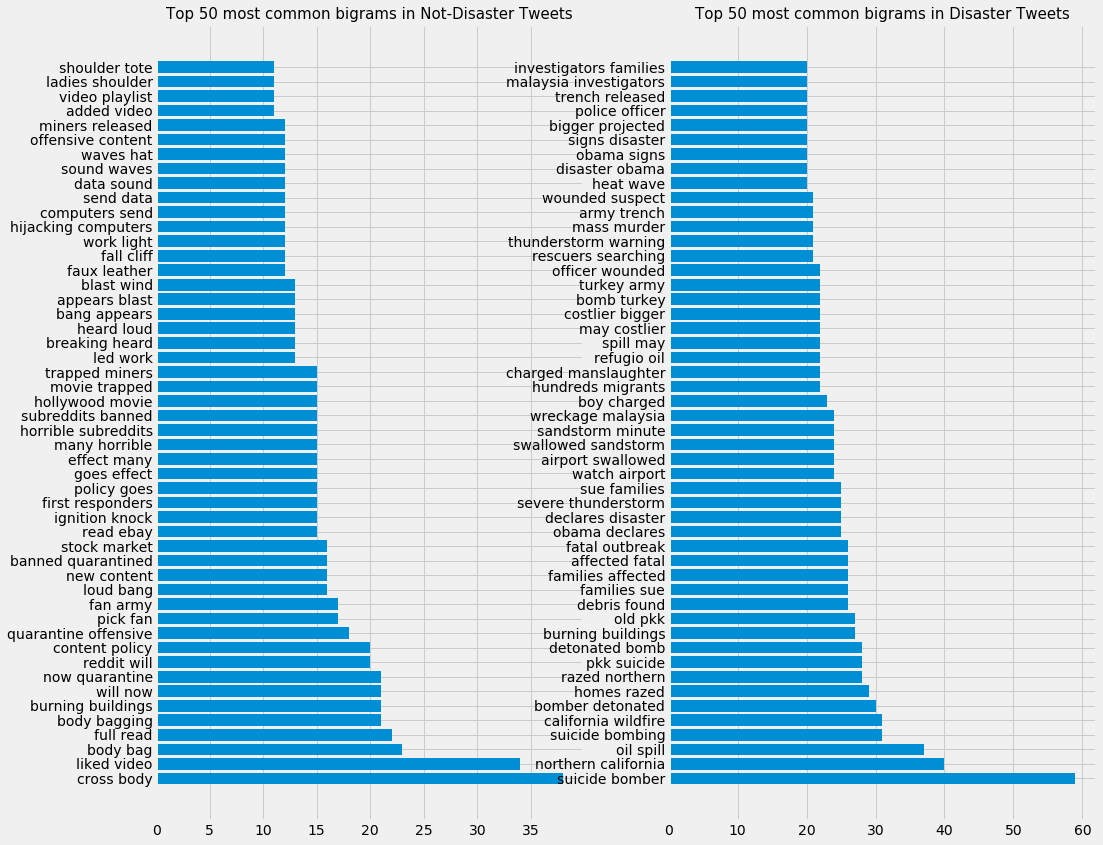

In [31]:
plt.figure(figsize=(15, 30))

plt.subplot(2, 2, 1)
plt.barh(list(not_disaster.keys()), list(not_disaster.values()))
plt.title('Top 50 most common bigrams in Not-Disaster Tweets', fontsize=15)

plt.subplot(2, 2, 2)
plt.barh(list(disaster.keys()), list(disaster.values()))
plt.title('Top 50 most common bigrams in Disaster Tweets', fontsize=15)

# **4.Embeddings Coverage**
When you have pre-trained embeddings, doing standard preprocessing steps  might not be a good idea because some of the valuable information can be lost. It is better to get vocabulary as close to embeddings as possible. In order to do that, train vocab and test vocab are created by counting the words in tweets.

Text cleaning is based on the embeddings below:
* GloVe-300d-840B
* FastText-Crawl-300d-2M

In [38]:
train.columns

Index(['id', 'keyword', 'text', 'target', 'word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count', 'clean_text'], dtype='object')

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = train.drop(['target', 'text', 'clean_text', 'keyword'], axis=1)
y = train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# cout_vect = CountVectorizer(ngram_range=(1, 2))
keyword_cv = CountVectorizer()
text_cv = CountVectorizer()

bow_keyword_train = keyword_cv.fit_transform(train.keyword).toarray()
bow_keyword_test = keyword_cv.transform(test.keyword).toarray()

bow_text_train = text_cv.fit_transform(train.clean_text).toarray()
bow_text_test = text_cv.transform(test.clean_text).toarray()

In [56]:
print(bow_keyword_train)
print(bow_keyword_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [45]:
print(f"X_TRAIN shape: {X_train.shape} ==> {type(X_train)}")
print(f"X_TEST shape: {X_test.shape}")

X_TRAIN shape: (11, 11) ==> <class 'scipy.sparse.csr.csr_matrix'>
X_TEST shape: (11, 11)


In [51]:
bow_train

<5329x147 sparse matrix of type '<class 'numpy.int64'>'
	with 5636 stored elements in Compressed Sparse Row format>

In [58]:
from sklearn.naive_bayes import MultinomialNB

X_train = train.clean_text
X_test = test.clean_text
y_train = train.target

text_cv = CountVectorizer()
X_train = text_cv.fit_transform(X_train)
X_test = text_cv.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [59]:
from sklearn.metrics import classification_report

y_pred = nb_model.predict(X_test)
# pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

In [ ]:
y_pred = nb_model.predict(X_train)
pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

In [62]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = y_pred
submission.to_csv('data/submission.csv', index=False)